In [1]:
#%%
#Import dependencies
from scipy.ndimage import rotate
import numpy as np
#%matplotlib notebook
import nibabel as nib
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
#import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign
image_file = '../visium_data/sccanals26/A1_mod.jpg'
V = plt.imread(image_file)
Vnorm = STalign.normalize(V)
I = Vnorm.transpose(2,0,1)
I=I[0:200,1500:4200,400:3000]

In [2]:
YI= np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
X_=np.arange(0, 1000, 1)
Y_=np.arange(0, 1000, 1)

xI = [Y_,X_]

import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(2,1,0) 
slice = 220


extentI = STalign.extent_from_x((YI,XI))


In [5]:
pointsIlist = np.load('../test/model_A1_points.npy', allow_pickle=True).tolist()
# print(pointsIlist)
pointsJlist = np.load('../test/visum_A1_points.npy', allow_pickle=True).tolist()
# print(pointsJlist)
pointsI = []
pointsJ = []

YI = (np.array(range(I.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = (np.array(range(I.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
I=I
 
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [7]:
I = STalign.normalize((I).astype(np.float64))
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
L,T = STalign.L_T_from_points(pointsI,pointsJ)

sigmaA = 0.18 #standard deviation of artifact intensities
sigmaB = 0.18 #standard deviation of background intensities
sigmaM = 0.18#standard deviation of matching tissue intenities

extentI = STalign.extent_from_x((YI,XI))


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Albert\Documents\GitHub\STalign\docs\notebooks\../../STalign\STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

5.14497391941269
5.206138646233556
5.262200556324173
5.315051350761291
5.37552993376529
5.432180563028439


C:\Users\Albert\Documents\GitHub\STalign\docs\notebooks\../../STalign\STalign.py:1142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figE,axE = plt.subplots(1,3)


5.485965515383459


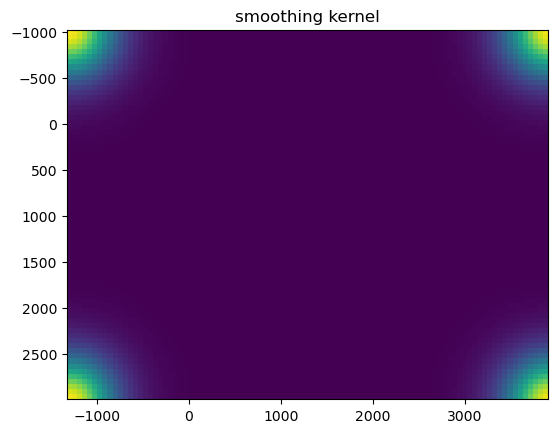

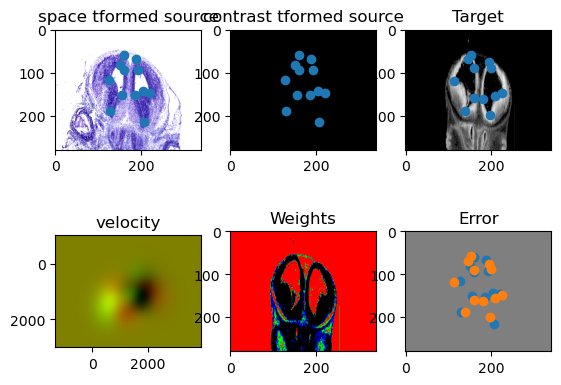

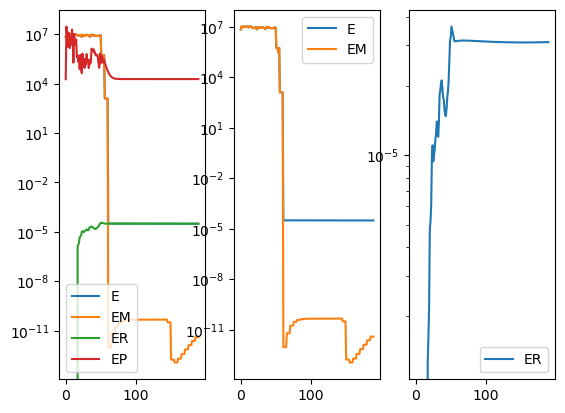

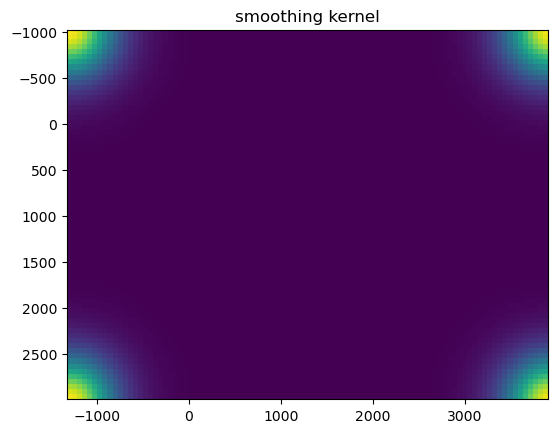

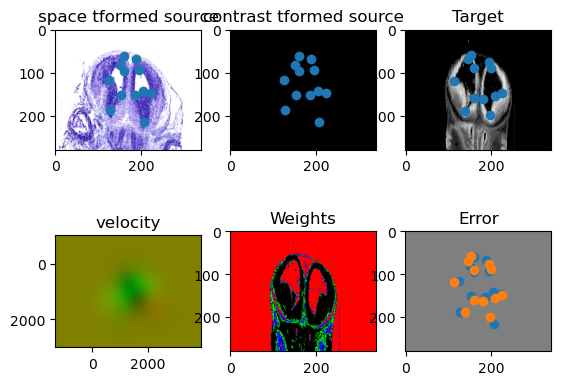

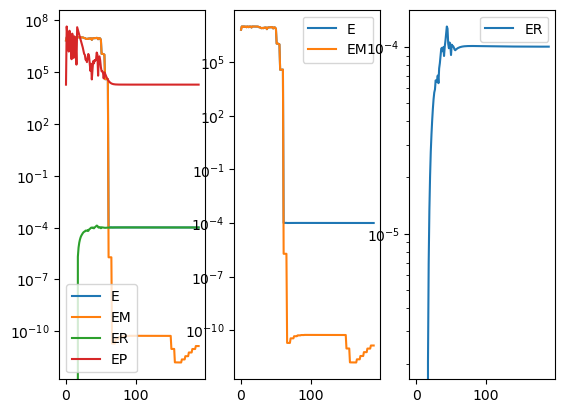

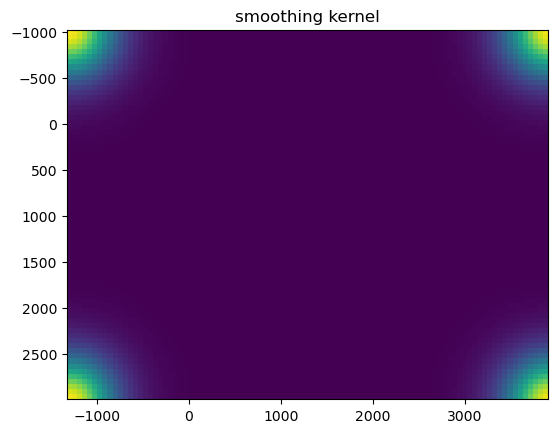

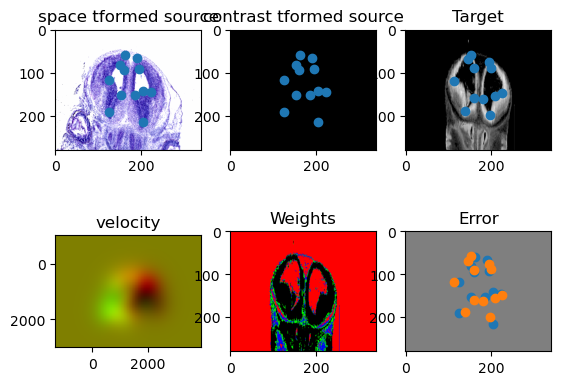

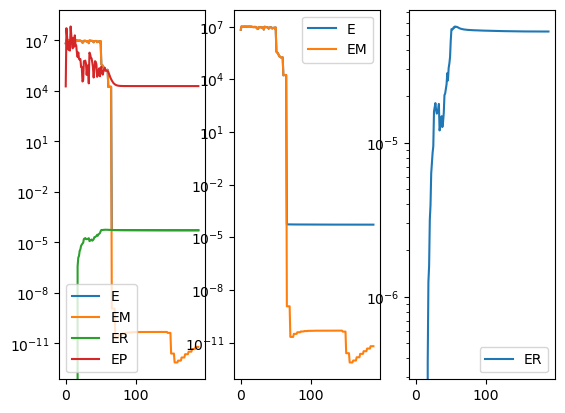

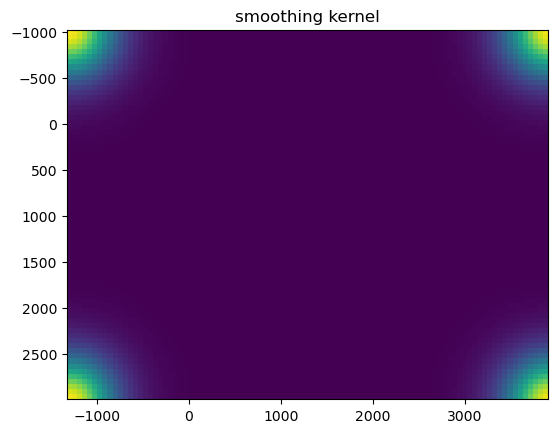

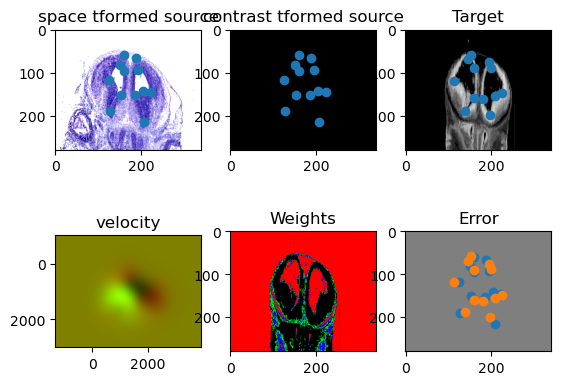

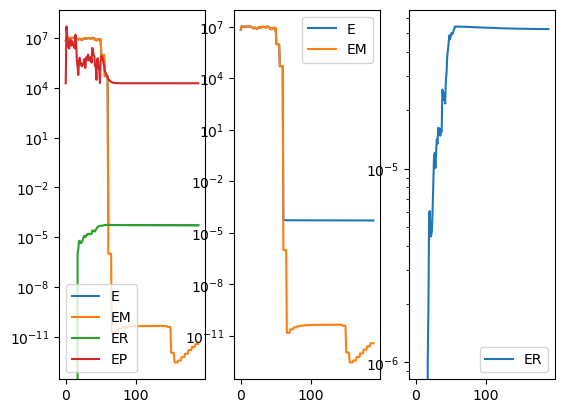

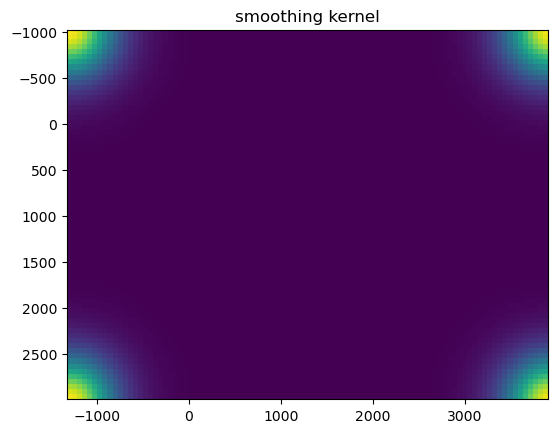

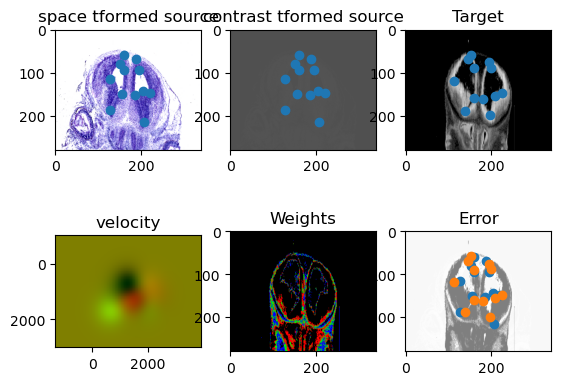

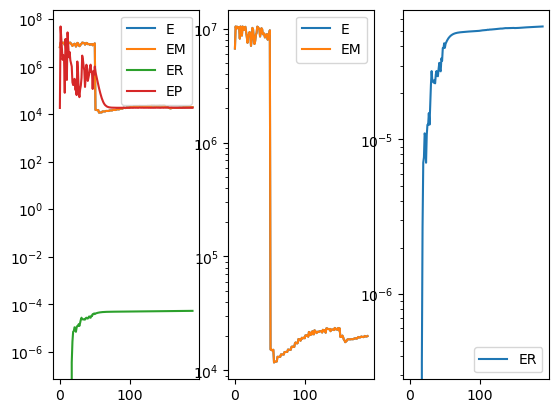

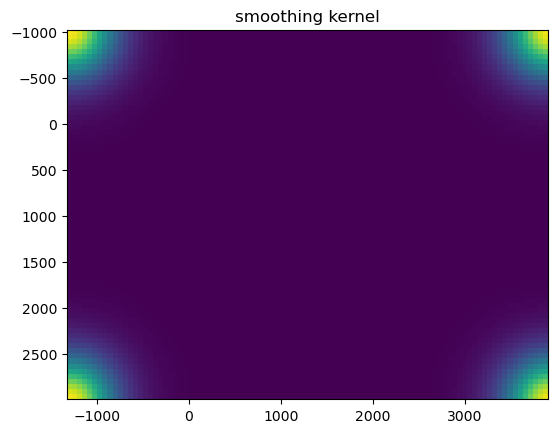

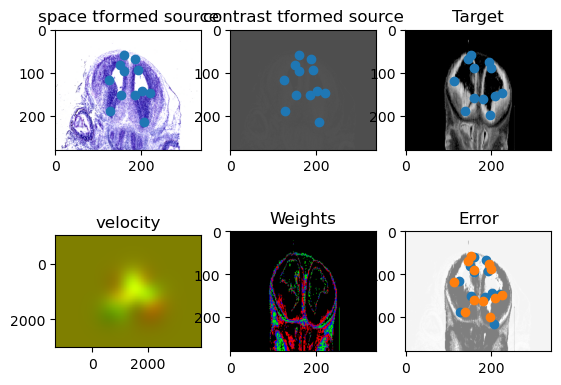

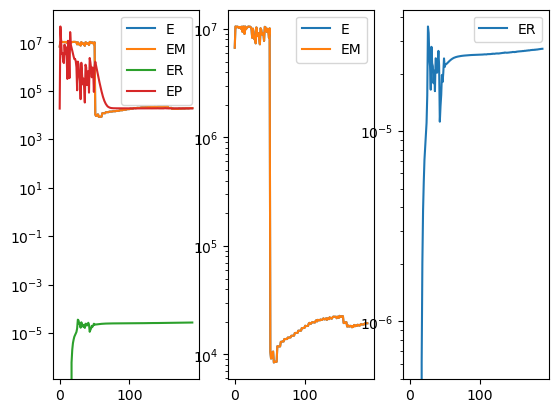

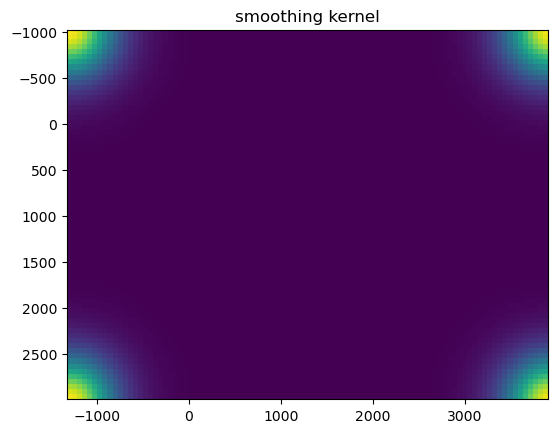

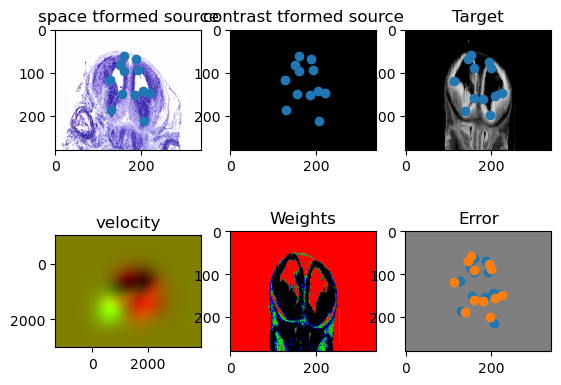

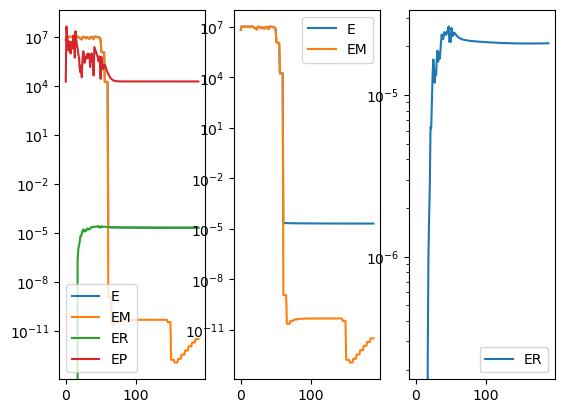

In [9]:
xI=[YI,XI]

err=10000
[9, 110, 3]
for i in range(0,7):
    slice = 220
    A = ct_scan.transpose(2,1,0) 
    J = (A[slice-3+i][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
    J=J[:,:280,:]
    J[J<1.]=0.
    XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64)
    YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64)
    extentJ = STalign.extent_from_x((YJ,XJ))
    J = np.vstack((J,J,J))
    xJ=[YJ,XJ]
    torch.cuda.empty_cache()
    transform = STalign.LDDMM(
    xI,I,xJ,J,
    L=L,T=T,
    pointsI= pointsI,
    pointsJ=pointsJ,
    nt=9,
    niter=200,
    diffeo_start = 16,
    device='cuda:0',
    a=110,
    p=3,
    sigmaP = 2e-1,
    epL= 5e-11,
    epT= 5e-3,
    epV= 5e-2,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    # muA = muA, #average of artifact intensities
    # muB = muB #average of background intensities
    )
    A = transform['A']
    v = transform['v']
    xv = transform['xv']
    phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
    if phiI.is_cuda:
        phiI = phiI.cpu()
    mse =((J - phiI.numpy())**2).mean(axis=None)
    print(mse)
    if mse <err:
        err=mse
        param=[i]

In [15]:
print(err)
print(param)

5.1454268695327805
[0]


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Albert\Documents\GitHub\STalign\docs\notebooks\../../STalign\STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


5.142777798673828
CPU times: total: 23.8 s
Wall time: 39.6 s


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\utils\_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


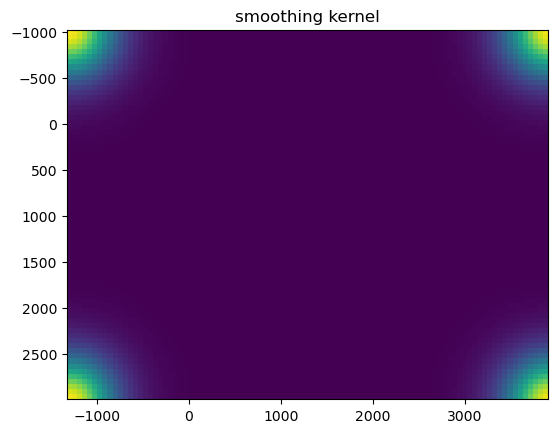

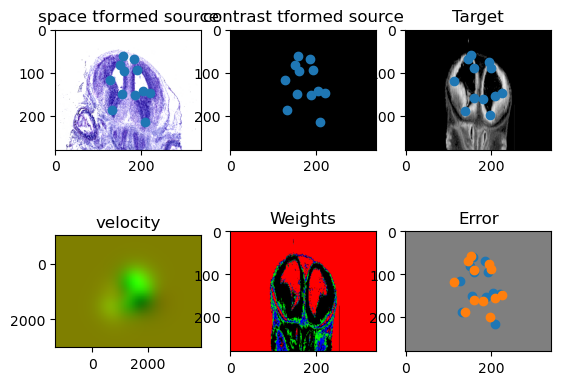

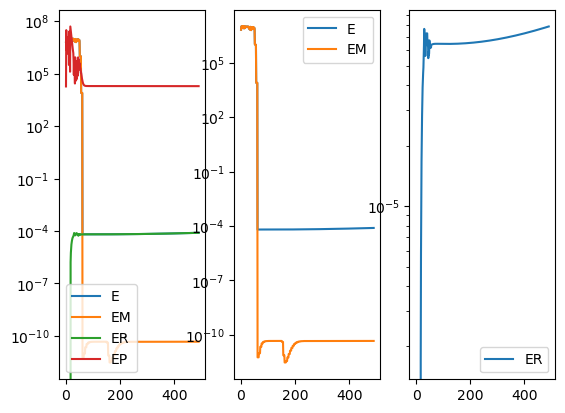

In [9]:
%%time
slice = 220
A = ct_scan.transpose(2,1,0) 
J = (A[slice-3][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:]
J[J<1.]=0.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64)
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64)
extentJ = STalign.extent_from_x((YJ,XJ))
J = np.vstack((J,J,J))
xJ=[YJ,XJ]
xI=[YI,XI]
xJ=[YJ,XJ]
torch.cuda.empty_cache()
transform = STalign.LDDMM(
xI,I,xJ,J,
L=L,T=T,
pointsI= pointsI,
pointsJ=pointsJ,
nt=9,
niter=500,
diffeo_start = 16,
device='cuda:0',
a=110,
p=3,
sigmaP = 2e-1,
epL= 8e-11,
epT= 5e-3,
epV= 5e-2,
sigmaA = sigmaA, #standard deviation of artifact intensities
sigmaB = sigmaB, #standard deviation of background intensities
sigmaM = sigmaM, #standard deviation of matching tissue intenities
# muA = muA, #average of artifact intensities
# muB = muB #average of background intensities
)
A = transform['A']
v = transform['v']
xv = transform['xv']
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
if phiI.is_cuda:
    phiI = phiI.cpu()
mse =((J - phiI.numpy())**2).mean(axis=None)
print(mse)

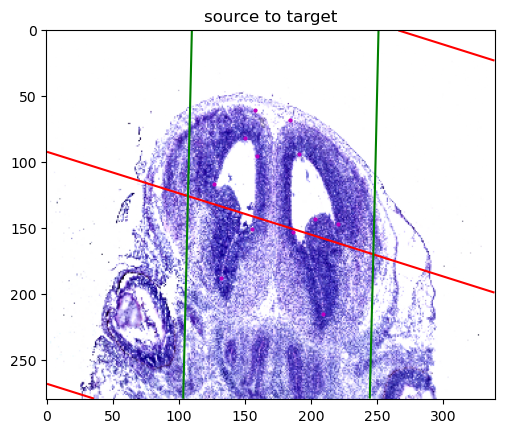

In [11]:




A = transform['A']
v = transform['v']
xv = transform['xv']
#Xs = transform['Xs']

WM = transform['WM'].tolist()
WB = transform['WB'].tolist()
WA = transform['WA'].tolist()
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsI)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()
if phiipointsI.is_cuda:
    phiipointsI = phiipointsI.cpu()


# plot with grids

fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),s=4,c="m")

mse = ((pointsJ - phiipointsI.numpy())**2).mean(axis=None)
mse =((J - phiI.numpy())**2).mean(axis=None)

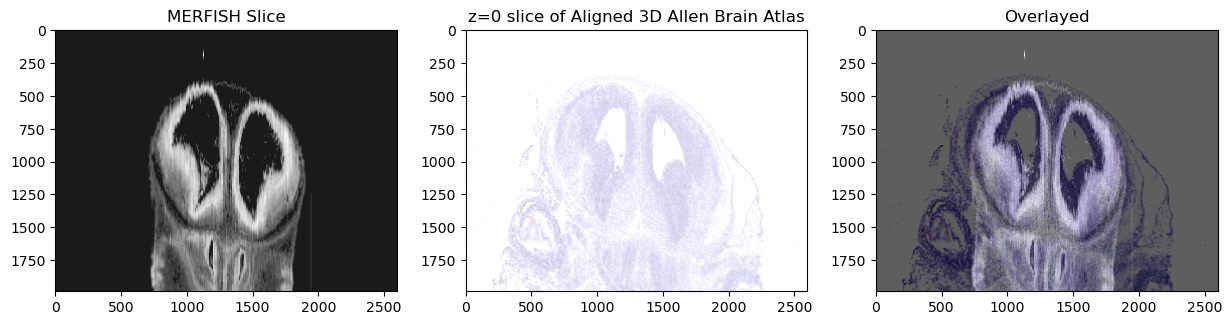

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointsI and pointsJ')

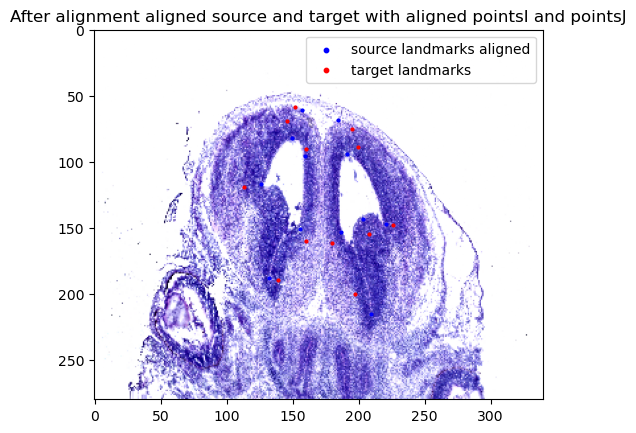

In [13]:
import matplotlib as mpl
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.transform_image_source_with_A(A,xI,I,xJ)

Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()


fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target.squeeze(), extent=extentI, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('MERFISH Slice')
ax1 = ax[1].imshow(AI.permute(1,2,0).cpu().squeeze(), extent=extentI, cmap = mpl.cm.Reds,alpha=0.2)
ax[1].set_title('z=0 slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target.squeeze(), extent=extentI, cmap = mpl.cm.Blues,alpha=0.9)
ax2 = ax[2].imshow(AI.permute(1,2,0).cpu().squeeze(), extent=extentI, cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()
#%%
import matplotlib as mpl
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ, cmap = mpl.cm.Reds,alpha =1)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="blue", label='source landmarks aligned', s=4)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=4)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ')

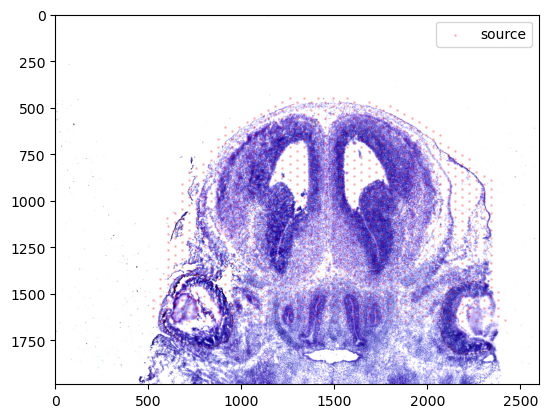

In [15]:
#I=I[0:200,1500:4200,400:3000]
fname = '../visium_data/sccanals26/A1_tissue_positions.csv'
df1 = pd.read_csv(fname)
df1=df1[df1["in_tissue"]==1]
df1=df1[df1["pxl_col_in_fullres"]>400]
df1=df1[df1["pxl_col_in_fullres"]<3000]
df1=df1[df1["pxl_row_in_fullres"]>1500]
df1=df1[df1["pxl_row_in_fullres"]<4200]

# get cell centroid coordinates
xI = (np.array(df1['pxl_col_in_fullres']-400)).astype(np.float64)
yI = (np.array(df1['pxl_row_in_fullres']-1500)).astype(np.float64)
test = Vnorm.transpose(2,0,1)
test=test[0:200,1500:4200,400:3000]
# plot
fig,ax = plt.subplots()
ax.imshow(test.transpose(1,2,0))
ax.scatter(xI,yI,c='red',s=1,alpha=0.2, label='source')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


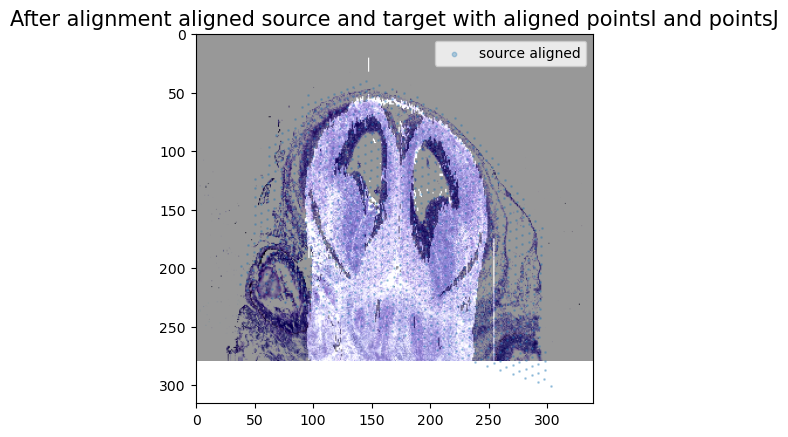

In [17]:
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ, cmap = mpl.cm.Reds,alpha =0.6)

ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.3, label = 'source aligned')

ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)
plt.savefig("my_plot.png")

In [57]:
volume = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(volume)

In [59]:
ct_scan.shape

(340, 673, 552)

In [62]:
df1["pxl_row_transformed"]=yI_LDDMM.numpy().astype(int).tolist()
df1["pxl_column_transformed"]=xI_LDDMM.numpy().astype(int).tolist()

In [65]:
cellprob=pd.read_csv("class_prediction_table_v1.txt",header=0,sep=",")
cellprob=cellprob[(cellprob["project"]=="SCCANALS26") &(cellprob["genotype"]=="WT")&(cellprob["litter"]=="SCC26_L1") ]
cellprob["cell_barcode"]=cellprob["cell_barcode"].apply(lambda x: x.split("_")[0])

In [67]:
Y_to_pred=pd.merge(df1,cellprob, left_on="barcode",right_on="cell_barcode")

In [69]:
Y_to_pred.to_excel("text.xlsx")

In [23]:
gen=gen[:,:250,:]
fig,ax = plt.subplots()
ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)
ax.imshow((gen).transpose(1,2,0),extent=extentJ,alpha=0.6)

NameError: name 'gen' is not defined

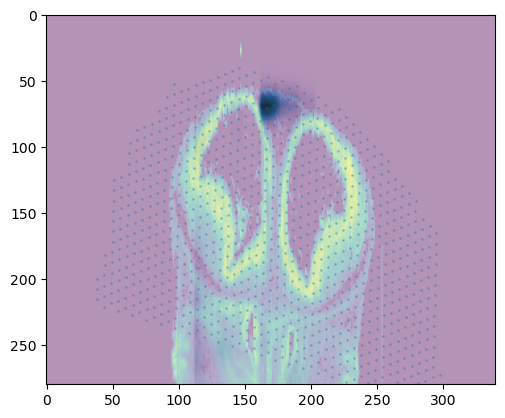

In [24]:
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
A = ct_scan.transpose(2,1,0) 
slice = 220-3
theta_deg = 0
gen_origin = sitk.ReadImage("./gen-download/gen_list/Zmat4/test.mhd")
gen_origin_resample=sitk.Resample(gen_origin,itkimage)
gen_scan = sitk.GetArrayFromImage(gen_origin_resample)

gen1 = gen_scan.transpose(2,1,0)
gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)


J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
J=J[:,:280,:]
J[J<1.]=0.
gen=gen[:,:280,:]
gen[gen<0.]=0.

 
YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 
fig,ax = plt.subplots()
extentJ = STalign.extent_from_x((YJ,XJ))

theta_deg = -(90+30)
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.3, label = 'source aligned')

ax.imshow((J[0:1].transpose(1,2,0).squeeze()), extent=extentJ)
ax.imshow((gen[0:1].transpose(1,2,0).squeeze()), extent=extentJ,cmap='PuBuGn',alpha =0.6) 
fig.canvas.draw()  


,pxl_row_in_fullres,pxl_col_in_fullres,pxl_row_transformed,pxl_column_transformed
0,3122,927,212,37
1,3078,927,204,37
2,3034,927,197,37
3,3145,965,218,42
4,3122,1004,215,48
...,...,...,...,...
1104,2522,2740,190,295
1105,2478,2740,182,295
1106,2434,2740,174,296
1107,2389,2740,166,296


In [71]:
from os import listdir
from os.path import isfile, join,isdir
import random

mypath="./gen-download/gen_list"
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
onlyfiles = [f for f in listdir(mypath) if isdir(join(mypath, f))]
onlyfiles=random.sample(onlyfiles,10)
X_for_pred=Y_to_pred[["pxl_row_in_fullres","pxl_col_in_fullres","pxl_row_transformed","pxl_column_transformed"]]
for i in range(len(onlyfiles)):
    if onlyfiles[i] not in X_for_pred:
                X_for_pred.loc[:,onlyfiles[i]] = 0.
    files=listdir(mypath+"/"+onlyfiles[i])
    for j in files:
        if ".mhd" in j :
            gen_origin = sitk.ReadImage(mypath+"/"+onlyfiles[i]+"/"+j)
            gen_origin_resample=sitk.Resample(gen_origin,itkimage)
            gen_scan = sitk.GetArrayFromImage(gen_origin_resample)        
            gen1 = gen_scan.transpose(2,1,0)
            gen = (gen1[slice][None] / np.mean(np.abs(gen1[slice]),keepdims=True)).astype(np.float64)  
            gen=gen[:,:280,:]
            gen[gen<0.]=0.
    
    for index, row in Y_to_pred.iterrows():
        if (row["pxl_row_transformed"]>=280):
            []       
        else:
            X_for_pred.loc[index,onlyfiles[i]]=gen[0,row["pxl_row_transformed"],row["pxl_column_transformed"]]

C:\Users\Albert\AppData\Local\Temp\ipykernel_13852\1729731112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_for_pred.loc[:,onlyfiles[i]] = 0.
C:\Users\Albert\AppData\Local\Temp\ipykernel_13852\1729731112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_for_pred.loc[:,onlyfiles[i]] = 0.
C:\Users\Albert\AppData\Local\Temp\ipykernel_13852\1729731112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
X_for_pred.loc[:,onlyfiles[1]]="a"

In [31]:
X_for_pred.to_excel("x.xlsx")
Y_to_pred.to_excel("y.xlsx")

In [ ]:
from os import listdir
from os.path import isfile, join,isdir
mypath="./gen-download/gen_list"
onlyfiles = [f for f in listdir(mypath) if isdir(join(mypath, f))]

In [ ]:
onlyfiles=random.sample(onlyfiles,10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


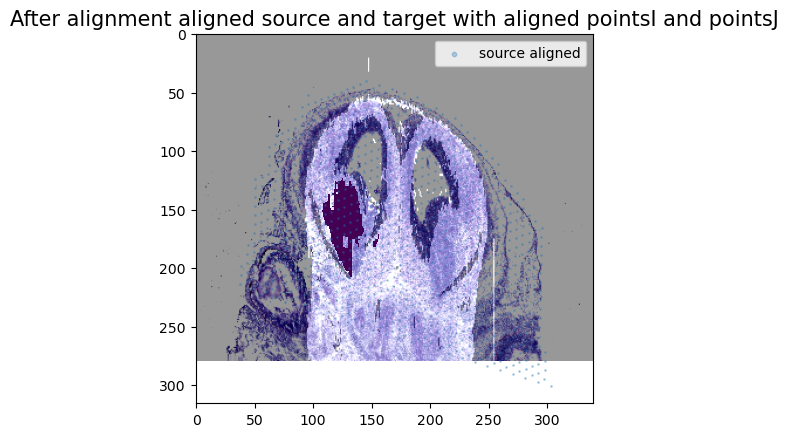

In [48]:
import SimpleITK as sitk
itkimage = sitk.ReadImage("../atlasVolume/estriat-Segment_15861-label.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
estriat = ct_scan.transpose(2,1,0) 
slice = 220-3

es = (estriat[slice][None] / np.mean(np.abs(estriat[slice]),keepdims=True)).astype(np.float64)
es=es[:,:280,:]
es[es<1.]=None

tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ,alpha=1)

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ, cmap = mpl.cm.Reds,alpha =0.6)
ax.imshow((es).transpose(1,2,0),extent=extentJ,alpha=1)
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.3, label = 'source aligned')

ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)
plt.savefig("my_plot.png")

In [75]:
X_for_pred["is_in_striatum"]=0
for index, row in Y_to_pred.iterrows():
        if (row["pxl_row_transformed"]>=280):
            []       
        else:
            X_for_pred.loc[index,"is_in_striatum"]=es[0,row["pxl_row_transformed"],row["pxl_column_transformed"]]

C:\Users\Albert\AppData\Local\Temp\ipykernel_13852\2701449166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_for_pred["is_in_striatum"]=0


In [79]:
len(X_for_pred[X_for_pred["is_in_striatum"]>100])

45